In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import zipfile

if torch.cuda.is_available():
    !nvidia-smi -L
else:
    print("No CUDA")
    
plt.rcParams["figure.figsize"] = (20,10)

GPU 0: GeForce MX150 (UUID: GPU-b9ee9c25-c61e-a61c-e7ec-be8a2ae28129)


In [2]:
import random

seed = 666

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
!kaggle competitions download -c platesv2

100%|██████████████████████████████████████| 47.0M/47.0M [00:04<00:00, 9.69MB/s]
100%|██████████████████████████████████████| 47.0M/47.0M [00:04<00:00, 10.7MB/s]


In [4]:
with zipfile.ZipFile("./platesv2.zip") as zip_obj:
    zip_obj.extractall("./temp")

with zipfile.ZipFile("./temp/plates.zip") as zip_obj:
    zip_obj.extractall("./dataset")

%rm temp/*
%rmdir temp/
%rm ./platesv2.zip

In [5]:
%pwd

'/home/quartz/Документы/Kaggle1'

In [2]:
data_root = "./dataset/plates/"

%ls $data_root

test/  train/


In [3]:
import shutil
from tqdm.notebook import tqdm

train_dir = "train"
# val_dir = "val"

class_names = ["cleaned", "dirty"]

# for dir_name in [train_dir, val_dir]:
#     for class_name in class_names:
#         os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
#         if i % 6 != 0:
#             dest_dir = os.path.join(train_dir, class_name)
#         else:
#             dest_dir = os.path.join(val_dir, class_name)
        dest_dir = os.path.join(train_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

NameError: name 'data_root' is not defined

In [4]:
# %ls val/* train/*
%ls train/*

train/cleaned:
0000.jpg  0003.jpg  0006.jpg  0009.jpg  0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg  0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg  0014.jpg  0017.jpg

train/dirty:
0000.jpg  0003.jpg  0006.jpg  0009.jpg  0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg  0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg  0014.jpg  0017.jpg


In [4]:
import PIL
import cv2 as cv

low_threshold = 20
blur_strength = 23

def hough_crop(image):
    """Finds a plate on the image and crops the image"""
    
    src = np.array(image.convert("RGB")).copy()
    
    proc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    proc = cv.medianBlur(proc, blur_strength)
    proc = cv.Canny(proc, low_threshold, low_threshold*3)

    rows = proc.shape[0]
    
    circles = cv.HoughCircles(proc, cv.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=30,
                               minRadius=30, maxRadius=130)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        m = np.max(circles, axis=1)[0][2]
        m = list(filter(lambda x: x[2] == m, circles[0, :]))[0]
        center = (int(m[0]), int(m[1]))
        radius = m[2]
    else:
        center = (int(src.shape[1]) // 2, int(src.shape[0]) // 2)
        radius = min(center) // 2
        
    radius /= np.sqrt(2)
        
    cr = 110
    pad = max(cr / 2 - radius, 0)
    
    left = int(max(center[1] - radius - pad, 0))
    right = int(min(center[1] + radius + pad, src.shape[0]))
    up = int(max(center[0] - radius - pad, 0))
    down = int(min(center[0] + radius + pad, src.shape[1]))
    
    proc = src[left:right, up:down]
    
    side = int(224 * np.sqrt(2))
    
#     proc = cv.resize(proc, (side, side))
    
    return PIL.Image.fromarray(proc)

In [5]:
import torchvision
from torchvision import transforms

# crop = 105

train_transforms = transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
#     transforms.RandomResizedCrop(crop),
    transforms.RandomRotation(360, expand=True),
    transforms.Lambda(lambda x: hough_crop(x)),
#     transforms.Pad(45, fill=0, padding_mode='reflect'),
#     transforms.RandomAffine(360, translate=[0, 0.2], scale=None, shear=None, resample=0, fillcolor=0),
#     transforms.CenterCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[np.random.permutation(3), :, :]),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.CenterCrop(224),
#     transforms.CenterCrop(crop),
#     transforms.Resize((224, 224)),
    
    transforms.Lambda(lambda x: hough_crop(x)),
#     transforms.Pad(45, fill=0, padding_mode='edge'),
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(5, 40)

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [6]:
def show_input(input_tensor, title=""):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    all_loss = []
    all_acc = []
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs - 1}:", flush=True)
        
        dataloader = train_dataloader
        model.train()

        running_loss = 0
        running_acc = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                loss_value.backward()
                optimizer.step()

            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        all_loss.append(epoch_loss)
        all_acc.append(epoch_acc.cpu())
        
        scheduler.step()

        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}", flush=True)
    return all_loss, all_acc

In [93]:
model = torchvision.models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)

losses, acces = train_model(model, loss, optimizer, scheduler, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4701 Acc: 0.4500
Epoch 1/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1119 Acc: 0.5750
Epoch 2/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6713 Acc: 0.4750
Epoch 3/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4046 Acc: 0.6750
Epoch 4/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7057 Acc: 0.7250
Epoch 5/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7930 Acc: 0.7000
Epoch 6/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3849 Acc: 0.8250
Epoch 7/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3950 Acc: 0.8000
Epoch 8/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4443 Acc: 0.8500
Epoch 9/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4365 Acc: 0.8000
Epoch 10/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1327 Acc: 0.9500
Epoch 11/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3154 Acc: 0.8500
Epoch 12/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1861 Acc: 0.9000
Epoch 13/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3236 Acc: 0.8750
Epoch 14/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2723 Acc: 0.9000
Epoch 15/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4872 Acc: 0.8500
Epoch 16/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1983 Acc: 0.9250
Epoch 17/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2506 Acc: 0.9000
Epoch 18/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4507 Acc: 0.7250
Epoch 19/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1517 Acc: 0.9500
Epoch 20/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1691 Acc: 0.9500
Epoch 21/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3283 Acc: 0.7500
Epoch 22/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2429 Acc: 0.9250
Epoch 23/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1560 Acc: 0.9500
Epoch 24/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1349 Acc: 0.9500
Epoch 25/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0907 Acc: 1.0000
Epoch 26/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1922 Acc: 0.9250
Epoch 27/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5222 Acc: 0.7500
Epoch 28/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2705 Acc: 0.8750
Epoch 29/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1553 Acc: 0.9500
Epoch 30/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1364 Acc: 0.9500
Epoch 31/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1877 Acc: 0.9000
Epoch 32/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2134 Acc: 0.8750
Epoch 33/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2275 Acc: 0.8750
Epoch 34/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1414 Acc: 0.9500
Epoch 35/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1392 Acc: 0.9750
Epoch 36/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1657 Acc: 0.9000
Epoch 37/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1039 Acc: 0.9500
Epoch 38/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0753 Acc: 0.9750
Epoch 39/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1209 Acc: 1.0000
Epoch 40/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2236 Acc: 0.9250
Epoch 41/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0750 Acc: 1.0000
Epoch 42/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2295 Acc: 0.9500
Epoch 43/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1303 Acc: 0.9750
Epoch 44/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1106 Acc: 0.9500
Epoch 45/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3031 Acc: 0.8750
Epoch 46/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1287 Acc: 0.9500
Epoch 47/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2694 Acc: 0.9250
Epoch 48/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1194 Acc: 0.9750
Epoch 49/49:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1400 Acc: 0.9500


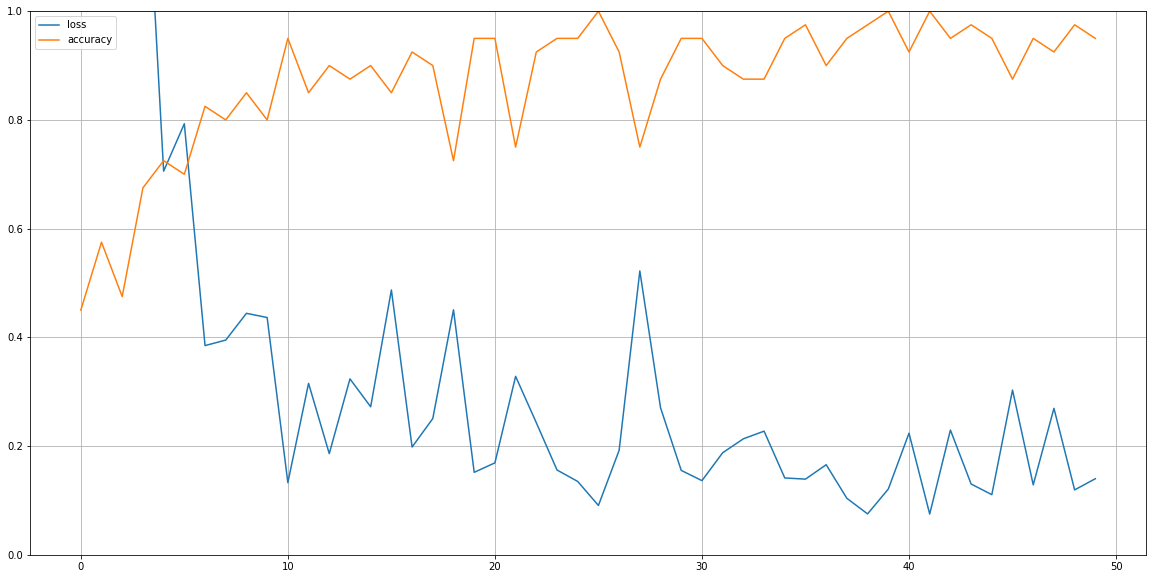

In [94]:
plt.plot(losses, label="loss")
plt.plot(acces, label="accuracy")
plt.legend()
plt.grid(True)
plt.ylim(0, 1);

In [14]:
test_dir = "test"
shutil.copytree(os.path.join(data_root, "test"), os.path.join(test_dir, "unknown"), dirs_exist_ok=True)

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [95]:
test_dataset = ImageFolderWithPaths("./test", val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:, 1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

  0%|          | 0/93 [00:00<?, ?it/s]

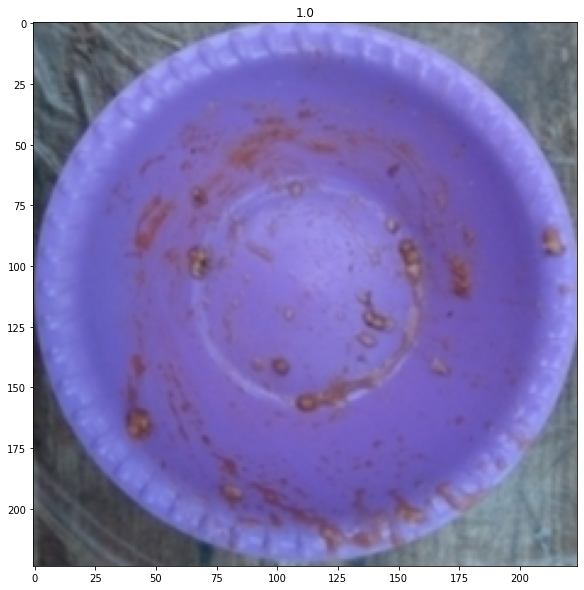

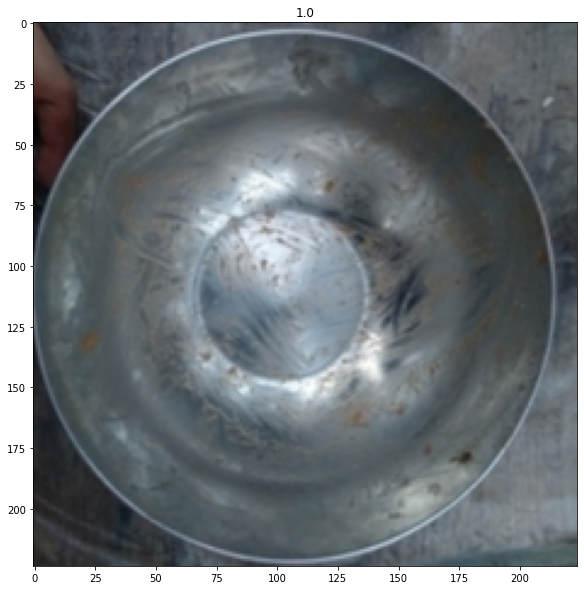

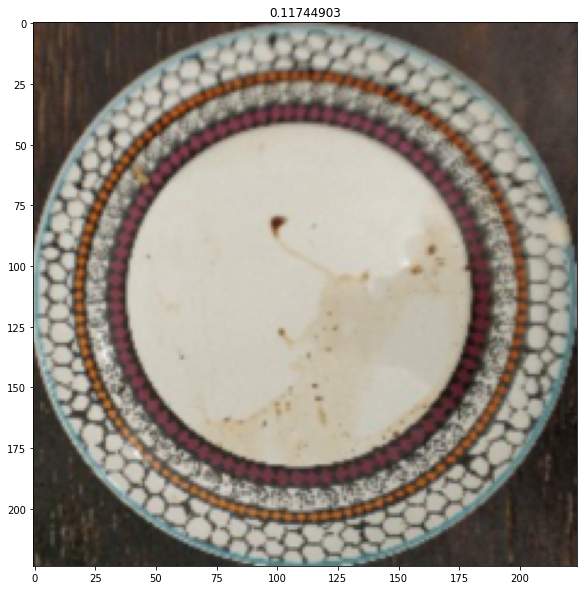

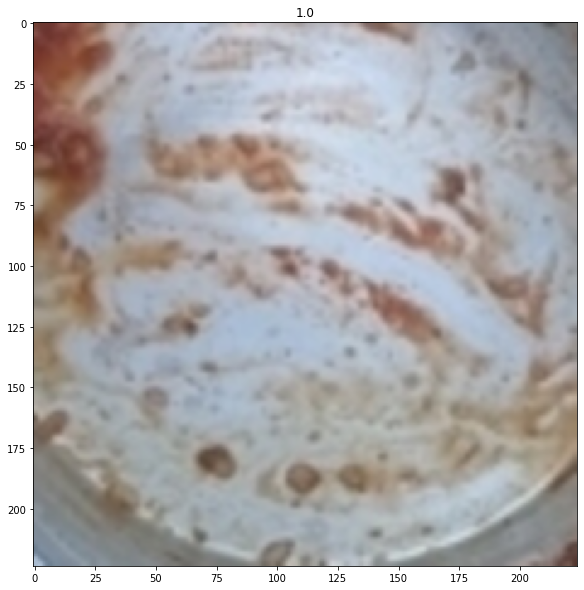

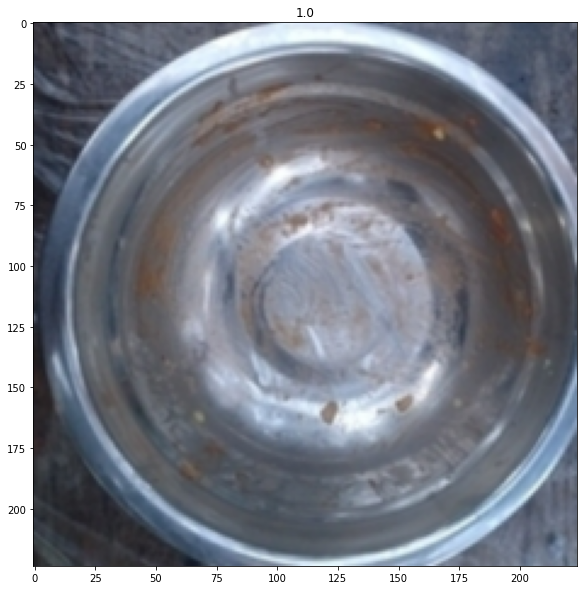

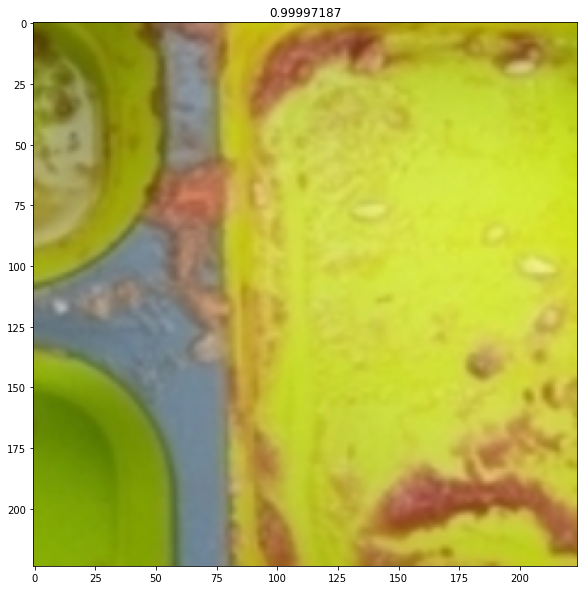

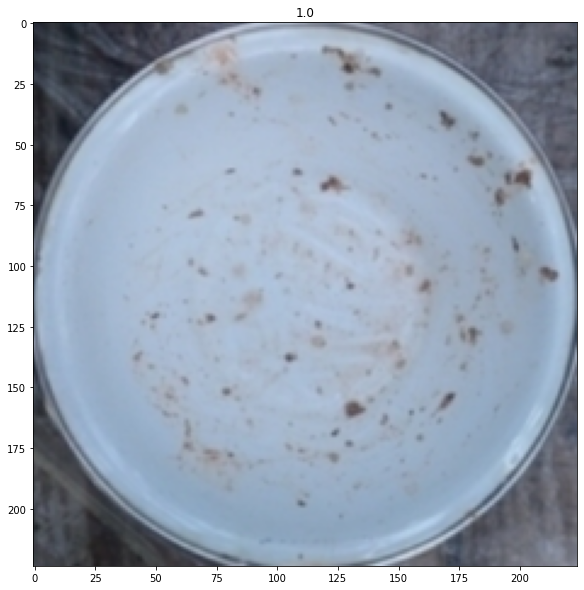

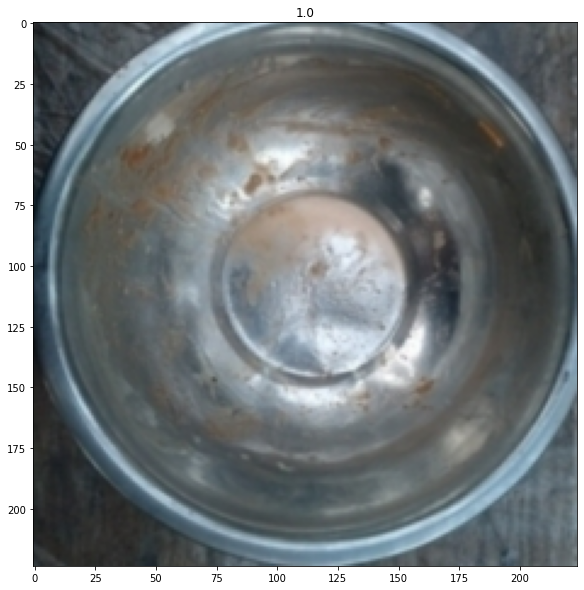

In [96]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
targets = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [96]:
import pandas as pd

threshold = 0.5

submission_df = pd.DataFrame.from_dict({"id": test_img_paths, "label": test_predictions})

submission_df["target"] = targets + [2] * (744 - len(targets))
submission_df["target"] = submission_df["target"]\
    .map(lambda pred: "dirty" if pred == 1 else "cleaned" if pred == 0 else "None")

submission_df["prob"] = submission_df["label"]
submission_df["label"] = submission_df["label"].map(lambda pred: "dirty" if pred > threshold else "cleaned")
submission_df["id"] = submission_df["id"].str.replace("./test/unknown/", "", regex=False)
submission_df["id"] = submission_df["id"].str.replace(".jpg", "", regex=False)

submission_df["check"] = submission_df["label"] == submission_df["target"]

submission_df.set_index("id", inplace=True)
print(submission_df[(submission_df["target"] != "None") & (submission_df["check"] == False)].count()[0])
submission_df.head(n=38)

5


,label,target,prob,check
id,,,,
0000,dirty,dirty,0.999445,True
0001,dirty,dirty,0.995541,True
0002,cleaned,dirty,0.374482,False
0003,dirty,dirty,0.997148,True
0004,dirty,dirty,0.875437,True
0005,dirty,dirty,0.986035,True
0006,dirty,dirty,0.999897,True
0007,dirty,dirty,0.987234,True
0008,dirty,dirty,0.976202,True


In [86]:
submission_df["label"].to_csv("submission.csv")

In [1]:
%rm -rf dataset/ train/ test/ val/

In [128]:
input();

d


In [87]:
from time import sleep
!kaggle competitions submit -c platesv2 -f submission.csv -m "..."
sleep(3)
%rm submission.csv

100%|██████████████████████████████████████| 8.51k/8.51k [00:05<00:00, 1.59kB/s]
Successfully submitted to Cleaned vs Dirty V2

In [88]:
!kaggle competitions submissions -c platesv2

fileName        date                 description                                status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------  --------  -----------  ------------  
submission.csv  2021-02-05 20:00:31  ...                                        complete  0.90188      None          
submission.csv  2021-02-05 19:32:21  vote                                       complete  0.89650      None          
submission.csv  2021-02-05 19:29:22  vote                                       complete  0.91666      None          
submission.csv  2021-02-05 19:25:54  200e                                       complete  0.90994      None          
submission.csv  2021-02-05 19:12:53  50e                                        complete  0.82526      None          
submission.csv  2021-02-05 18:57:22  no rot                                     complete  0.83736      None          
submission.csv  2021-02-05 18:27:52  pad 45             

In [46]:
torch.save(model, "model_90994.pt")

In [51]:
model = torch.load("model_91532.pt")

In [47]:
%ls model*

model_74865.pt  model_88575.pt  model_90188.pt  model_91532.pt
model_87500.pt  model_89247.pt  model_90994.pt  model_92204.pt
model_87903.pt  model_89516.pt  model_91397.pt


In [53]:
models = [torch.load("model_90188.pt"),
          torch.load("model_90994.pt"),
          torch.load("model_91532.pt"),]
predictions = []
for model in models:
    
    test_dataset = ImageFolderWithPaths("./test", val_transforms)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model.eval()

    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)
    predictions.append(test_predictions)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [54]:
submission_df = pd.DataFrame.from_dict({"id": test_img_paths})

for i in range(len(predictions)):
    key = f"{i + 1}"
    submission_df[key] = predictions[i]

submission_df["id"] = submission_df["id"].str.replace("./test/unknown/", "", regex=False)
submission_df["id"] = submission_df["id"].str.replace(".jpg", "", regex=False)

submission_df.set_index("id", inplace=True)

for i in range(len(predictions)):
    key = f"{i + 1}"
    submission_df[key] = submission_df[key].map(lambda pred: 1 if pred > threshold else 0)
    
submission_df["mean"] = submission_df.mean(axis=1)
submission_df["label"] = submission_df["mean"].map(lambda pred: "dirty" if pred > threshold else "cleaned")

submission_df["target"] = targets + [2] * (744 - len(targets))
submission_df["target"] = submission_df["target"]\
    .map(lambda pred: "dirty" if pred == 1 else "cleaned" if pred == 0 else "None")

submission_df["check"] = submission_df["label"] == submission_df["target"]

print(submission_df[(submission_df["target"] != "None") & (submission_df["check"] == False)].count()[0])

submission_df.head(38)[~submission_df["check"]]

3


<ipython-input-54-d527fa64d84f>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  submission_df.head(38)[~submission_df["check"]]


,1,2,3,mean,label,target,check
id,,,,,,,
0002,1,0,0,0.333333,cleaned,dirty,False
0023,1,0,0,0.333333,cleaned,dirty,False
0027,0,1,1,0.666667,dirty,cleaned,False


# Предобработка
Попытки отделить тарелку от фона

In [2]:
from PIL import Image, ImageDraw

%ls train/cleaned

0000.jpg  0003.jpg  0006.jpg  0009.jpg  0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg  0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg  0014.jpg  0017.jpg


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

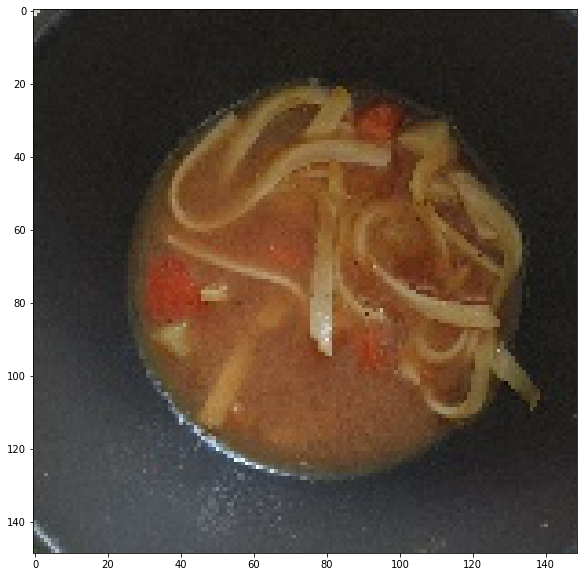

In [6]:
img = Image.open(r"train/dirty/0009.jpg")

a = hough_crop(img)

plt.imshow(a)

In [7]:
import cv2 as cv

In [24]:
import re

# path = "train/cleaned/"
path = "train/dirty/"
# path = "test/unknown/"

low_threshold = 20
blur_strength = 11

def mag(a):
    a = a[:]
    a = a.
    return (a[0]**2 + a[1]**2)**(1/2)

for i, f in enumerate(sorted(filter(lambda x: re.match(r"\d+\.\w+", x), os.listdir(path)))):
    src = cv.imread(cv.samples.findFile(path + f), cv.IMREAD_COLOR)
    proc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    proc = cv.medianBlur(proc, blur_strength)
    proc = cv.Canny(proc, low_threshold, low_threshold*3)

    rows = proc.shape[0]
    
    circles = cv.HoughCircles(proc, cv.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=30,
                               minRadius=30, maxRadius=130)
    print(src.shape)
    if circles is not None:
        circles = np.uint16(np.around(circles))
#         ma = np.max(circles, axis=1)[0][2]
        ma = np.array([0, 0, 0])
#         ma = list(filter(lambda x: x[2] == m, circles[0,:]))[0]
        for m in circles[0, :]:
            ic = (src.shape[1] // 2, src.shape[0] // 2)
            center = (m[0], m[1])
            c = np.array([center[0], center[1]])
            if mag(c - np.array(ma[:-1])) < mag(c - np.array([m[:-1]])):
                ma = m
            # circle center
            cv.circle(src, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = m[2]
            cv.circle(src, center, radius, (255, 0, 255), 3)
        cv.circle(src, (ma[0], ma[1]), ma[2], (255, 255, 0), 3)
    else:
        center = (src.shape[1] // 2, src.shape[0] // 2)
        radius = min(center) // 2
        cv.circle(src, center, radius, (128, 255, 128), 3)
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(proc)
    ax[1].imshow(src)
    plt.title(f)
    plt.show()

(256, 342, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [8]:
# import re

# path = "train/cleaned/"
# # path = "train/dirty/"
# # path = "test/unknown/"

# low_threshold = 20
# blur_strength = 23

# for i, f in enumerate(sorted(filter(lambda x: re.match(r"\d+\.\w+", x), os.listdir(path)))):
#     src = cv.imread(cv.samples.findFile(path + f), cv.IMREAD_COLOR)
#     proc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
#     proc = cv.medianBlur(proc, blur_strength)
#     proc = cv.Canny(proc, low_threshold, low_threshold*3)

#     rows = proc.shape[0]
    
#     circles = cv.HoughCircles(proc, cv.HOUGH_GRADIENT, 1, rows / 8,
#                                param1=100, param2=30,
#                                minRadius=30, maxRadius=130)
    
#     if circles is not None and len(circles) > 0:
#         circles = np.uint16(np.around(circles))
#         m = np.max(circles, axis=1)[0][2]
#         m = list(filter(lambda x: x[2] == m, circles[0,:]))[0]
# #         for m in circles[0, :]:
#         center = (int(m[0]), int(m[1]))
#         # circle center
#         cv.circle(src, center, 1, (0, 100, 100), 3)
#         # circle outline
#         radius = m[2]
#         cv.circle(src, center, radius, (255, 0, 255), 3)
#     else:
#         center = (int(src.shape[1]) // 2, int(src.shape[0]) // 2)
#         radius = min(center) // 2
#         cv.circle(src, center, radius, (128, 255, 128), 3)
        
#     radius /= np.sqrt(2)
        
#     left = int(max(center[1] - radius, 0))
#     right = int(min(center[1] + radius, src.shape[0]))
#     up = int(max(center[0] - radius, 0))
#     down = int(min(center[0] + radius, src.shape[1]))
    
#     print(f"{radius=}, {center=}, {left=}, {right=}, {up=}, {down=}, {src.shape=}")
    
#     proc = src[left:right, up:down]
    
#     _, ax = plt.subplots(1, 2)
#     ax[0].imshow(proc)
#     ax[1].imshow(src)
#     plt.title(f)
#     plt.show()